In [2]:
import pandas as pd
import missingno as msno

In [3]:
fd_df = pd.read_csv('data/sdf_flights_clean.csv')
wd_df = pd.read_csv('data/weather_data.csv')

---

# All-in-one function to merge flight and weather DFs

---

In [4]:
def flight_weather_merge(fd_df, wd_df):
    """
    Merge flight operations data with hourly weather observations.

    The function aligns each flight with the closest previous weather
    observation (within a 1-hour tolerance) based on scheduled departure time.
    A time-aware merge (`merge_asof`) is used to ensure correct chronological
    matching.

    Processing steps:
        - Convert date and time columns to pandas datetime objects.
        - Normalize CRS departure time into hour and minute components.
        - Construct full datetime timestamps for both flights and weather data.
        - Perform backward time-based merge within 1-hour tolerance.
        - Remove flights for which no matching weather record is found.
        - Report the number of removed flights.

    Args:
        fd_df (pd.DataFrame): Flight dataset containing at minimum:
            - FlightDate
            - CRSDepTime
            - Origin, Dest (for reporting)
        wd_df (pd.DataFrame): Weather dataset containing:
            - date
            - time (HHMM format)
            - weather feature columns

    Returns:
        pd.DataFrame: Merged dataset with weather features attached
        to each flight record. Flights without valid weather data
        are removed.

    Notes:
        - CRSDepTime values with invalid minute components (>59)
          are treated as missing.
        - The merge uses backward matching (nearest previous weather record).
        - A tolerance of 1 hour is applied.
        - The input DataFrames are copied to avoid in-place modification.
    """
    
    fd_df = fd_df.copy()
    wd_df = wd_df.copy()
    
    # DateTime pandas object
    fd_df["FlightDate"] = pd.to_datetime(fd_df["FlightDate"], errors="coerce")
    wd_df["date"] = pd.to_datetime(wd_df["date"], errors="coerce")
    
    wd_df["time"] = pd.to_numeric(wd_df["time"], errors="coerce").astype("Int64")

    # CRSDepTime could be float (1754.0) or str -> to Int64
    fd_df["CRSDepTime"] = pd.to_numeric(fd_df["CRSDepTime"], errors="coerce").astype("Int64")

    # Hours and minutes track
    hh = (fd_df["CRSDepTime"] // 100).fillna(0).astype(int)
    mm = (fd_df["CRSDepTime"] % 100).fillna(0).astype(int)

    # If minutes > 59 (in case of noisy data) -> NaN
    bad = mm > 59
    hh = hh.mask(bad)
    mm = mm.mask(bad)

    # Combine date data
    fd_df["dt"] = fd_df["FlightDate"] + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")
    wd_hh = (wd_df["time"] // 100).fillna(0).astype(int)
    wd_df["dt"] = wd_df["date"] + pd.to_timedelta(wd_hh, unit="h")
    
    # Merging datasets
    
    fd_df = fd_df.sort_values("dt")
    wd_df = wd_df.sort_values("dt")

    df_merged = pd.merge_asof(
        fd_df,
        wd_df,
        on="dt",
        direction="backward",
        tolerance=pd.Timedelta("1h")
    )
    
    # Drop 122 flights because they couldn`t find their respective weather data at 1h tolerance
    miss = df_merged[df_merged["HourlyDryBulbTemperature"].isna()][
        ["FlightDate","CRSDepTime","dt","Origin","Dest"]
    ]
    # Printing number of missing weather data flights
    print(f"Missing weather data for {miss.shape[0]} flights")
    print("Deleting these flights...")
    # Drop all these flights
    df_merged = df_merged.dropna(subset=['HourlyDryBulbTemperature']).reset_index(drop=True)
    print(f'Merged dataset is ready to use')
    
    return df_merged

In [5]:
df = flight_weather_merge(fd_df, wd_df)

Missing weather data for 122 flights
Deleting these flights...
Merged dataset is ready to use


In [6]:
df.to_csv('data/flight_weather_merged.csv', index=False)

In [7]:
df = pd.read_csv('data/flight_weather_merged.csv')
df.head()

,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginCityName,...,HourlyWindGustSpeed,HourlyWindSpeed,time,HourlyWeatherType,HourlySkyCondit,wind_dir_sin,wind_dir_cos,wind_dir_vrb,airport,date
0,1,1,1,1,2024-01-01,AA,N871NN,1653.0,SDF,"Louisville, KY",...,0.0,7.0,500,snow,cloudy,-0.939693,0.34202,0.0,SDF,2024-01-01
1,1,1,1,1,2024-01-01,NK,N657NK,1201.0,SDF,"Louisville, KY",...,0.0,8.0,600,snow,cloudy,-0.866025,0.50000,0.0,SDF,2024-01-01
2,1,1,1,1,2024-01-01,DL,N844DN,2574.0,SDF,"Louisville, KY",...,0.0,8.0,600,snow,cloudy,-0.866025,0.50000,0.0,SDF,2024-01-01
3,1,1,1,1,2024-01-01,WN,N8789Q,3175.0,SDF,"Louisville, KY",...,0.0,8.0,600,snow,cloudy,-0.866025,0.50000,0.0,SDF,2024-01-01
4,1,1,1,1,2024-01-01,AA,N662AW,1694.0,SDF,"Louisville, KY",...,0.0,8.0,600,snow,cloudy,-0.866025,0.50000,0.0,SDF,2024-01-01


---

# Compile code below only for illustrative purpose and testing

---

In [13]:
# date
fd_df["FlightDate"] = pd.to_datetime(fd_df["FlightDate"], errors="coerce")

# CRSDepTime could be float (1754.0) or str -> to Int64
fd_df["CRSDepTime"] = pd.to_numeric(fd_df["CRSDepTime"], errors="coerce").astype("Int64")

# hours and minutes
hh = (fd_df["CRSDepTime"] // 100).fillna(0).astype(int)
mm = (fd_df["CRSDepTime"] % 100).fillna(0).astype(int)

# if minutes > 59 -> в NaN
bad = mm > 59
hh = hh.mask(bad)
mm = mm.mask(bad)

fd_df["dt"] = fd_df["FlightDate"] + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")

In [14]:
wd_df["date"] = pd.to_datetime(wd_df["date"], errors="coerce")
wd_df["time"] = pd.to_numeric(wd_df["time"], errors="coerce").astype("Int64")

wd_hh = (wd_df["time"] // 100).fillna(0).astype(int)

wd_df["dt"] = wd_df["date"] + pd.to_timedelta(wd_hh, unit="h")

In [15]:
fd_df = fd_df.sort_values("dt")
wd_df = wd_df.sort_values("dt")

df_merged = pd.merge_asof(
    fd_df,
    wd_df,
    on="dt",
    direction="backward",
    tolerance=pd.Timedelta("1h")
)


In [16]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47640 entries, 0 to 47639
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Quarter                          47640 non-null  int64         
 1   Month                            47640 non-null  int64         
 2   DayofMonth                       47640 non-null  int64         
 3   DayOfWeek                        47640 non-null  int64         
 4   FlightDate                       47640 non-null  datetime64[ns]
 5   Reporting_Airline                47640 non-null  object        
 6   Tail_Number                      47640 non-null  object        
 7   Flight_Number_Reporting_Airline  47640 non-null  float64       
 8   Origin                           47640 non-null  object        
 9   OriginCityName                   47640 non-null  object        
 10  OriginState                      47640 non-null  object   

Axes(0.125,0.11;0.698618x0.77)


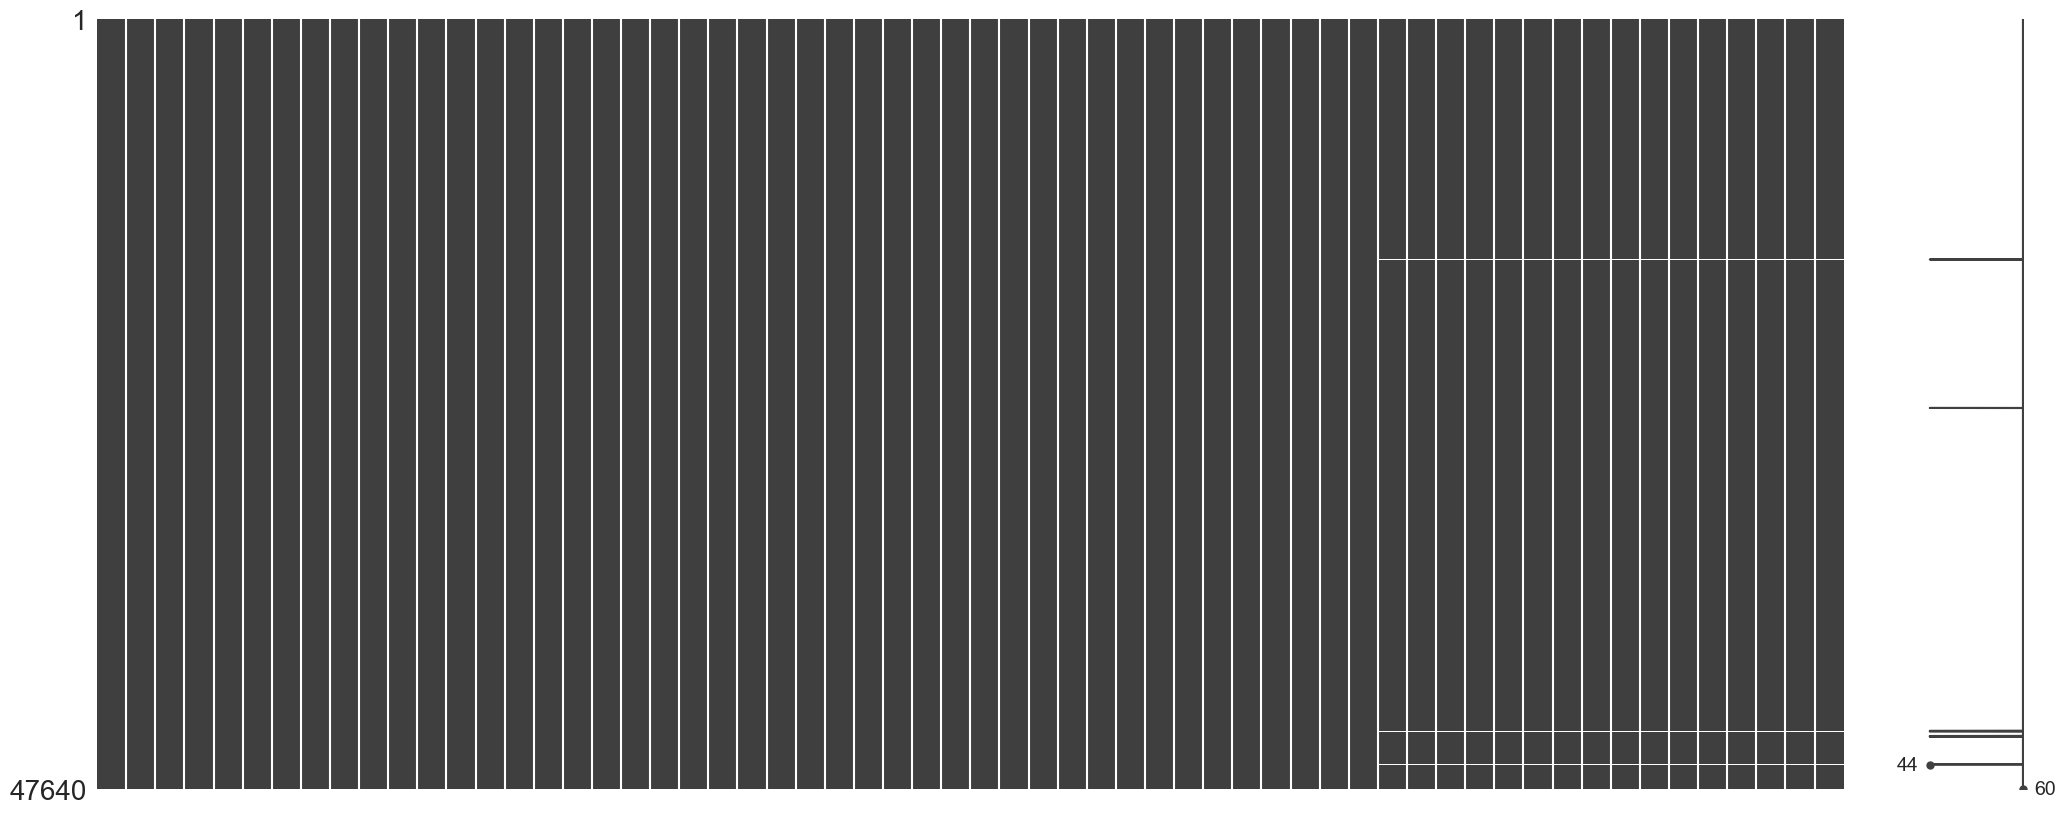

In [17]:
print(msno.matrix(df_merged))

In [18]:
miss = df_merged[df_merged["HourlyDryBulbTemperature"].isna()][
    ["FlightDate","CRSDepTime","dt","Origin","Dest"]
]
miss

,FlightDate,CRSDepTime,dt,Origin,Dest
14878,2024-04-30,2105,2024-04-30 21:05:00,ORD,SDF
14879,2024-04-30,2130,2024-04-30 21:30:00,MCO,SDF
14880,2024-04-30,2135,2024-04-30 21:35:00,DTW,SDF
14881,2024-04-30,2150,2024-04-30 21:50:00,MIA,SDF
24064,2024-07-04,614,2024-07-04 06:14:00,SDF,DCA
...,...,...,...,...,...
46125,2024-12-18,801,2024-12-18 08:01:00,SDF,LGA
46126,2024-12-18,810,2024-12-18 08:10:00,SDF,ATL
46127,2024-12-18,825,2024-12-18 08:25:00,ATL,SDF
46128,2024-12-18,835,2024-12-18 08:35:00,DTW,SDF


In [19]:
miss.shape

(122, 5)

## Because of the time zones, 122 flights couldn`t find their respective weather conditions,thus its only 122/47640 = 0.26% flights out of all dataset, we can remove these flights

In [20]:
df_merged.shape[0] - miss.shape[0]

47518

In [21]:
df_merged = df_merged.dropna(subset=['HourlyDryBulbTemperature']).reset_index(drop=True)

In [22]:
df_merged.shape

(47518, 60)

In [29]:
#df_merged.to_csv('data/flight_weather_merged.csv', index=False)